# Layer Analytics of TensorFlow Models

In [1]:
import os, sys, math, datetime
import psutil

# import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image

# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model
# from mltk.utils.commander import query_platform

import tensorflow as tf
# import tensorflow_datasets as tfds
#from tensorflow import keras
keras = tf.keras
from keras.layers import (
    Input,
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    BatchNormalization,
    Concatenate,
)

# import workbench.config.config
from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths

In [2]:
# Configure pandas to show all columns & rows
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [3]:
models_dir = initialize()

In [4]:
automated = True

#model_name = "mobilenetv1vvw_0.25_96_c3_o2_vvw"
#model_name = "efficientNetB0_0.1_96_c3_o3_keras"
model_name = "mobilenetv1_0.25_96_c3_o2_l5"

In [5]:
(
    models_path,
    models_summary_path,
    models_image_path,
    models_layer_df_path,
    models_tf_path,
    models_tflite_path,
    models_tflite_opt_path,
) = create_filepaths(model_name)

i:\tinyml\tiny_cnn\models


In [6]:
models_layer_df_path.is_file()

True

# Get the model

In [7]:
model = keras.models.load_model(models_tf_path)

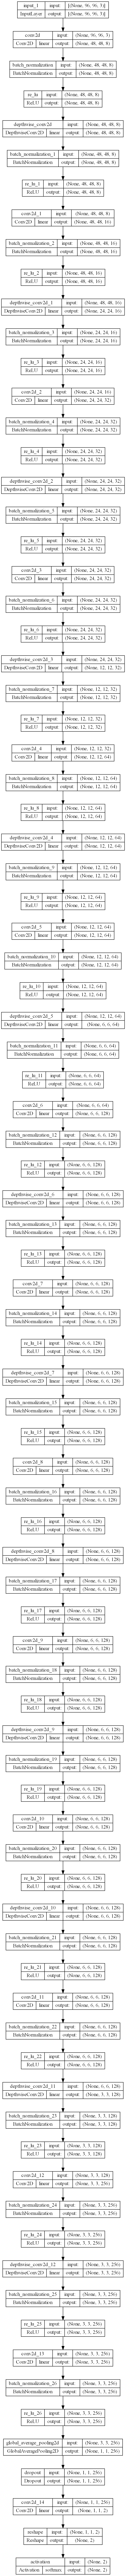

In [8]:
if automated == False:
    tf.keras.utils.plot_model(
        model,
        to_file=models_image_path,
        show_shapes=True,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",  # TB for vertical plot, LR for horizontal plot
        expand_nested=True,
        layer_range=None,
        dpi=200,
        show_layer_activations=True,
    )

In [9]:
mltk_summary = summarize_model(model)
print(mltk_summary)

Model: "mobilenetv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 8)         224       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 8)        32        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 48, 48, 8)         0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 48, 48, 8)        80        
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 8)        

# Helper Functions

In [10]:
def Conv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/conv.py
    """

    if isinstance(layer, keras.layers.Conv2D):
        _, _, _, in_depth = layer.input_shape  # layer.input_data.shape
        _, out_h, out_w, out_depth = layer.output_shape  # layer.output_data.shape
    else:
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    w_h, w_w = layer.kernel_size
    name = layer.name
    macs = w_h * w_w * in_depth * out_w * out_h * out_depth
    ops = macs * 2

    if layer.use_bias:
        ops += out_w * out_h * out_depth

    return (name, macs, ops)

In [11]:
def DepthwiseConv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/depthwise_conv.py
    """

    # if isinstance(layer, TfliteDepthwiseConv2dLayer):
    #     _, _, _, in_depth = layer.input_data.shape
    #     _, out_h, out_w, out_depth = layer.output_data.shape

    # else: keras.layers.DepthwiseConv2D
    if isinstance(layer, keras.layers.DepthwiseConv2D):
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    w_h, w_w = layer.kernel_size
    depth_multiplier = out_depth // in_depth

    name = layer.name
    macs = w_h * w_w * depth_multiplier * in_depth * out_w * out_h
    ops = macs * 2

    if layer.use_bias:
        ops += depth_multiplier * in_depth * out_w * out_h

    return (name, macs, ops)

In [12]:
def SeparableConv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/depthwise_conv.py
    """
    name = layer.name
    if isinstance(layer, keras.layers.SeparableConv2D):
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    else:
        return (name, "mac_error", "ops_error")

    w_h, w_w = layer.kernel_size

    macs_depth = w_h * w_w * in_depth * out_w * out_h
    macs_point = in_depth * out_w * out_h * out_depth
    macs = macs_depth + macs_point
    ops = macs * 2

    if layer.use_bias:
        ops += in_depth * out_w * out_h  # for depthwise convolution
        ops += (
            out_w * out_h * out_depth
        )  # for pointwise convolution ## TODO: check the calculations

    return (name, macs, ops)

In [13]:
def Dense_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/dense.py
    """

    if isinstance(layer, keras.layers.Dense):
        bias_ops = 0
        # if isinstance(layer, TfliteFullyConnectedLayer):
        #     in_depth = layer.input_data.shape[-1]
        #     out_depth = layer.output_data.shape[-1]
        #     if layer.use_bias:
        #         bias_ops = layer.outputs[0].shape.flat_size
        # else:
        in_depth = layer.input_shape[-1]
        out_depth = layer.output_shape[-1]
        if layer.use_bias:
            bias_ops = flat_size(layer.output_shape[1:])

        name = layer.name
        macs = in_depth * out_depth
        ops = macs * 2 + bias_ops

    return (name, macs, ops)

In [14]:
def AveragePooling2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/pooling.py
    """

    if isinstance(layer, keras.layers.AveragePooling2D):
        f_h, f_w = layer.pool_size
        name = layer.name
        # if isinstance(layer, KerasLayer):
        output_shape = layer.output_shape
        # else:
        #     output_shape = layer.outputs[0].shape

        ops = flat_size(output_shape[1:]) * (f_h * f_w + 1)  # + 1 for the division

    return (name, ops)

In [1]:
def parse_layer_input(layer_input):
    """Parses the tf.model.layers.input and extracts the following node infos:
        - node_name(s) of all input nodes
        - node_type(s) of all input nodes

    Args:
        layer_input (tf.model.layers.input): _description_

    Returns:
        dict: Dictionary containing the extracted node input infos
    """
    input_dict = {}
    if type(layer_input) is list:
        for i, item in enumerate(layer_input, start=1):
            try:
                node_name, node_type = item.__dict__['_name'].split("/")
                input_dict[f"input_node_{i}"] = node_name
                input_dict[f"input_node_type_{i}"] = node_type
            except:
                pass

    # elif tf.is_tensor(layer_input):
    #     print("Tensor!") # TODO: This part is not yet producing the correct outputs
    #     #input_dict["input_node_1"] = layer_input.name
    #     input_dict["input_1_shape"] = layer_input#[0].shape        
    else:
        try:
            print(f"Layer: {i}: {type(layer_input)}")
            node_name, node_type = layer_input.__dict__['_name'].split("/")
            input_dict["input_node_1"] = node_name
            input_dict["input_node_type_1"] = node_type
        except:
            print(f"Layer: : #EXCEPTION {type(layer_input)}")
            input_dict["input_node_1"] = layer_input.__dict__['_name']

    return input_dict

In [16]:
def print_layer_config(layer, layer_type):
    if isinstance(layer, layer_type):
        print(f"  Layer: {type(layer)}")
        print(layer.get_config())
        print()
    else:
        pass
    return layer.layer_config

In [17]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}:")
    print(layer.get_config())
    print("\n")

Layer 0:
{'batch_input_shape': (None, 96, 96, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}


Layer 1:
{'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 8, 'kernel_size': (3, 3), 'strides': (2, 2), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


Layer 2:
{'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([3]), 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', '

# Extract Layer Infos

In [18]:
def get_layer_list(model):
    layer_list = []
    for i, layer in enumerate(model.layers):
        layer_stats = {}
        layer_stats["index"] = i
        layer_stats["layer_name"] = layer.name
        layer_stats["layer_type"] = type(layer)  # TODO: find a better representation
        layer_stats["input_shape"] = layer.input_shape

        layer_stats["input"] = layer.input

        layer_input_dict = parse_layer_input(layer.input)
        layer_stats |= layer_input_dict # new Python 3.9 dict merge operation 
        #layer_stats.update(layer_input_dict)

        layer_stats["output_shape"] = layer.output_shape
        layer_stats["dtype"] = layer.compute_dtype
        layer_stats["params"] = layer.count_params()
        layer_stats["variables"] = len(layer.variables)
        try:
            layer_stats["weights_shape"] = layer.weights[0].shape
            layer_stats["weights_name"] = layer.weights[0].name
            layer_stats["weights_dtype"] = layer.weights[0].dtype
            #layer_stats["#_activations"] = calculate_no_activations(layer)

        except:
            layer_stats["weights_shape"] = 0
            layer_stats["weights_name"] = 0
            layer_stats["weights_dtype"] = 0
            layer_stats["#_activations"] = 0


        layer_config = layer.get_config()

        # Set default values for parameters that are not present in each layer
        layer_stats["OPS"] = 0
        layer_stats["MACS"] = 0
        layer_stats["filters"] = 0
        layer_stats["trainable"] = 0
        layer_stats["kernel_size"] = 0
        layer_stats["strides"] = 0
        layer_stats["padding"] = 0
        layer_stats["dilation_rate"] = 0
        layer_stats["groups"] = 0
        layer_stats["activation"] = 0
        layer_stats["use_bias"] = 0
        layer_stats["data_format"] = 0

        # if isinstance(layer, keras.layers.InputLayer):
        #     print(f"  Layer: {type(layer)}")
        #     print(layer_config)
        #     print()

        if isinstance(layer, keras.layers.Conv2D):
            # print(f"  Layer: {type(layer)}")
            # print(layer_config)
            # print()
            name, macs, ops = Conv2D_MACs(layer)

            layer_stats["OPS"] = ops
            layer_stats["MACS"] = macs
            # layer_stats["# activation"] = layer.output_shape[1]
            layer_stats["filters"] = layer_config["filters"]
            layer_stats["trainable"] = layer_config["trainable"]
            layer_stats["kernel_size"] = layer_config["kernel_size"]
            layer_stats["strides"] = layer_config["strides"]
            layer_stats["padding"] = layer_config["padding"]
            layer_stats["dilation_rate"] = layer_config["dilation_rate"]
            layer_stats["groups"] = layer_config["groups"]
            layer_stats["activation"] = layer_config["activation"]
            layer_stats["use_bias"] = layer_config["use_bias"]
            layer_stats["data_format"] = layer_config["data_format"]

        if isinstance(layer, keras.layers.DepthwiseConv2D):
            # print(f"  Layer: {type(layer)}")
            # print(layer_config)
            # print()

            name, macs, ops = DepthwiseConv2D_MACs(layer)

            # layer_stats["filters"]= layer_config["filters"]  # TODO: key error -> refactor with Conv2D
            layer_stats["OPS"] = ops
            layer_stats["MACS"] = macs
            layer_stats["trainable"] = layer_config["trainable"]
            layer_stats["kernel_size"] = layer_config["kernel_size"]
            layer_stats["strides"] = layer_config["strides"]
            layer_stats["padding"] = layer_config["padding"]
            layer_stats["dilation_rate"] = layer_config["dilation_rate"]
            layer_stats["groups"] = layer_config["groups"]
            layer_stats["activation"] = layer_config["activation"]
            layer_stats["use_bias"] = layer_config["use_bias"]
            layer_stats["data_format"] = layer_config["data_format"]

        # if isinstance(layer, keras.layers.Dense):
        #     print(f"  Layer: {type(layer)}")
        #     print(layer_config)
        #     print()

        # if isinstance(layer, keras.layers.BatchNormalization ):
        #     print(f"  Layer: {type(layer)}")
        #     print(layer_config)
        #     print()
        layer_list.append(layer_stats)
    return layer_list

In [19]:
layer_list = get_layer_list(model)

Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_t

In [20]:
df = pd.DataFrame.from_dict(layer_list)
df.head(20)

,index,layer_name,layer_type,input_shape,input,input_node_1,output_shape,dtype,params,variables,weights_shape,weights_name,weights_dtype,#_activations,OPS,MACS,filters,trainable,kernel_size,strides,padding,dilation_rate,groups,activation,use_bias,data_format
0,0,input_1,<class 'keras.engine.input_layer.InputLayer'>,"[(None, 96, 96, 3)]","KerasTensor(type_spec=TensorSpec(shape=(None, ...",input_1,"[(None, 96, 96, 3)]",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,conv2d,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 96, 96, 3)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",input_1,"(None, 48, 48, 8)",float32,224,2,"(3, 3, 3, 8)",conv2d/kernel:0,<dtype: 'float32'>,NaN,1013760,497664,8,True,"(3, 3)","(2, 2)",same,"(1, 1)",1,linear,True,channels_last
2,2,batch_normalization,<class 'keras.layers.normalization.batch_norma...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",conv2d/BiasAdd:0,"(None, 48, 48, 8)",float32,32,4,(8),batch_normalization/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0
3,3,re_lu,<class 'keras.layers.activation.relu.ReLU'>,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",batch_normalization/FusedBatchNormV3:0,"(None, 48, 48, 8)",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,depthwise_conv2d,<class 'keras.layers.convolutional.depthwise_c...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",re_lu/Relu:0,"(None, 48, 48, 8)",float32,80,2,"(3, 3, 8, 1)",depthwise_conv2d/depthwise_kernel:0,<dtype: 'float32'>,NaN,350208,165888,0,True,"(3, 3)","(1, 1)",same,"(1, 1)",1,linear,True,channels_last
5,5,batch_normalization_1,<class 'keras.layers.normalization.batch_norma...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",depthwise_conv2d/BiasAdd:0,"(None, 48, 48, 8)",float32,32,4,(8),batch_normalization_1/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0
6,6,re_lu_1,<class 'keras.layers.activation.relu.ReLU'>,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",batch_normalization_1/FusedBatchNormV3:0,"(None, 48, 48, 8)",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
7,7,conv2d_1,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",re_lu_1/Relu:0,"(None, 48, 48, 16)",float32,144,2,"(1, 1, 8, 16)",conv2d_1/kernel:0,<dtype: 'float32'>,NaN,626688,294912,16,True,"(1, 1)","(1, 1)",valid,"(1, 1)",1,linear,True,channels_last
8,8,batch_normalization_2,<class 'keras.layers.normalization.batch_norma...,"(None, 48, 48, 16)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",conv2d_1/BiasAdd:0,"(None, 48, 48, 16)",float32,64,4,(16),batch_normalization_2/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0
9,9,re_lu_2,<class 'keras.layers.activation.relu.ReLU'>,"(None, 48, 48, 16)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",batch_normalization_2/FusedBatchNormV3:0,"(None, 48, 48, 16)",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# check for errors
df[df["OPS"]=="ops_error"]

,index,layer_name,layer_type,input_shape,input,input_node_1,output_shape,dtype,params,variables,weights_shape,weights_name,weights_dtype,#_activations,OPS,MACS,filters,trainable,kernel_size,strides,padding,dilation_rate,groups,activation,use_bias,data_format


In [22]:
df["layer_type"].unique()

array([<class 'keras.engine.input_layer.InputLayer'>,
       <class 'keras.layers.convolutional.conv2d.Conv2D'>,
       <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>,
       <class 'keras.layers.activation.relu.ReLU'>,
       <class 'keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D'>,
       <class 'keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>,
       <class 'keras.layers.regularization.dropout.Dropout'>,
       <class 'keras.layers.reshaping.reshape.Reshape'>,
       <class 'keras.layers.core.activation.Activation'>], dtype=object)

# Helper Functions for clean-up

In [23]:
def split_tuples(x):
    x = str(x).strip("()")
    x = x.split(",")
    return x

In [24]:
def return_batch_size(x):
    x = str(x).strip("()")
    split_strings = x.split(",")
    #print(split_strings)
    return split_strings[0].strip()

In [25]:
def return_input_height(x):
    #image_size=(img_height, img_width),

    x = str(x).strip("()")
    split_strings = x.split(",")
    if len(split_strings) in [3,4]:
        return split_strings[1].strip()
    else:
        return "None"

In [26]:
def return_input_width(x):
    #image_size=(img_height, img_width),

    x = str(x).strip("()")
    split_strings = x.split(",")
    if len(split_strings) in [4]:
        return split_strings[2].strip()
    else:
        return "None"

In [27]:
def return_channels(x):
    x = str(x).strip("()")
    split_strings = x.split(",")
    #print(split_strings)

    return split_strings[-1].strip()

In [28]:
def split_shape_columns(df, colum_name):
    df[colum_name] = df[colum_name].map(str)
    df[colum_name] = df[colum_name].str.strip("[]").replace('\)\,', ')*', regex=True)
    df_cols = df[colum_name].str.split("*", expand=True) # TODO: check if this really splits 3 columns! e.g EfficientNet
    prefix = colum_name.split("_")[0]
    df_cols.columns = [f"{prefix}_{x+1}" for x in df_cols.columns]
    return df_cols

# Input channels

In [29]:
# df_input = split_shape_columns(df, "input_shape")
# no_input_cols = len(df_input.columns)
# for input in range(1,no_input_cols+1):
#     df_input[f"b_i_{input}"]= df_input[f"input_{input}"].apply(return_batch_size)
#     df_input[f"h_i_{input}"] = df_input[f"input_{input}"].apply(return_input_height)
#     df_input[f"w_i_{input}"] = df_input[f"input_{input}"].apply(return_input_width)
#     df_input[f"c_i_{input}"] = df_input[f"input_{input}"].apply(return_channels)



# df_input["b_i_1"].replace('None', np.nan, inplace=True)
# df_input["w_i_1"].replace('None', np.nan, inplace=True)
# df_input["h_i_1"].replace('None', np.nan, inplace=True)
# df_input["c_i_1"].replace('None', np.nan, inplace=True)

# df_input.fillna(1, inplace=True)

# # cast to int is required as a separate step
# df_input["w_i_1"] = df_input["w_i_1"].map(int)
# df_input["h_i_1"] = df_input["h_i_1"].map(int)
# df_input["b_i_1"] = df_input["b_i_1"].map(int)
# df_input["c_i_1"] = df_input["c_i_1"].map(int)


# # getting column names to check if there are additional columns
# input_cols = df_input.columns.to_list()

# if "b_i_2" in input_cols:
#     df_input["b_i_2"] = df_input["b_i_2"].str.replace("\(", "")
#     df_input["b_i_2"].replace('None', np.nan, inplace=True)
#     df_input["w_i_2"].replace('None', np.nan, inplace=True)
#     df_input["h_i_2"].replace('None', np.nan, inplace=True)
#     df_input["c_i_2"].replace('None', np.nan, inplace=True)

#     df_input.fillna(1, inplace=True)

#     # cast to int
#     df_input["b_i_2"] = df_input["b_i_2"].map(int)
#     df_input["w_i_2"] = df_input["w_i_2"].map(int)
#     df_input["h_i_2"] = df_input["h_i_2"].map(int)
#     df_input["c_i_2"] = df_input["c_i_2"].map(int)



In [30]:
# df_output =split_shape_columns(df, "output_shape") # TODO: This split does not work for EfficientNet
# no_output_cols = len(df_output.columns)
# # split output dimensions
# for output in range(1,no_output_cols+1):
#     df_output[f"b_o_{output}"]= df_output[f"output_{output}"].apply(return_batch_size)
#     df_output[f"h_o_{output}"] = df_output[f"output_{output}"].apply(return_input_height)
#     df_output[f"w_o_{output}"] = df_output[f"output_{output}"].apply(return_input_width)
#     df_output[f"c_o_{output}"] = df_output[f"output_{output}"].apply(return_channels)

# # fill NaN with 1 for mulitplication
# df_output["b_o_1"].replace('None', np.nan, inplace=True)
# df_output["w_o_1"].replace('None', np.nan, inplace=True)
# df_output["h_o_1"].replace('None', np.nan, inplace=True)
# df_output["c_o_1"].replace('None', np.nan, inplace=True)
# df_output.fillna(1, inplace=True)

# df_output["w_o_1"] = df_output["w_o_1"].map(int)
# df_output["h_o_1"] = df_output["h_o_1"].map(int)
# df_output["b_o_1"] = df_output["b_o_1"].map(int)
# df_output["c_o_1"] = df_output["c_o_1"].map(int)

In [31]:
df_input = split_shape_columns(df, "input_shape")
no_input_cols = len(df_input.columns)
for output in range(1,no_input_cols+1):
    df_input[f"b_i_{output}"]= df_input[f"input_{output}"].apply(return_batch_size)
    df_input[f"h_i_{output}"] = df_input[f"input_{output}"].apply(return_input_height)
    df_input[f"w_i_{output}"] = df_input[f"input_{output}"].apply(return_input_width)
    df_input[f"c_i_{output}"] = df_input[f"input_{output}"].apply(return_channels)

    df_input.replace("", 0, inplace=True)
    df_input.replace('(None', 'None', inplace=True)
    df_input.replace('None', np.nan, inplace=True)
    df_input.fillna(1, inplace=True)

    df_input[f"b_i_{output}"] = df_input[f"b_i_{output}"].map(int)
    df_input[f"h_i_{output}"] = df_input[f"h_i_{output}"].map(int)
    df_input[f"w_i_{output}"] = df_input[f"w_i_{output}"].map(int)
    df_input[f"c_i_{output}"] = df_input[f"c_i_{output}"].map(int)


df_input

,input_1,b_i_1,h_i_1,w_i_1,c_i_1
0,"(None, 96, 96, 3)",1,96,96,3
1,"(None, 96, 96, 3)",1,96,96,3
2,"(None, 48, 48, 8)",1,48,48,8
3,"(None, 48, 48, 8)",1,48,48,8
4,"(None, 48, 48, 8)",1,48,48,8
...,...,...,...,...,...
82,"(None, 3, 3, 256)",1,3,3,256
83,"(None, 1, 1, 256)",1,1,1,256
84,"(None, 1, 1, 256)",1,1,1,256
85,"(None, 1, 1, 2)",1,1,1,2


In [32]:
df_output = split_shape_columns(df, "output_shape")
no_output_cols = len(df_output.columns)

for output in range(1,no_output_cols+1):
    df_output[f"b_o_{output}"]= df_output[f"output_{output}"].apply(return_batch_size)
    df_output[f"h_o_{output}"] = df_output[f"output_{output}"].apply(return_input_height)
    df_output[f"w_o_{output}"] = df_output[f"output_{output}"].apply(return_input_width)
    df_output[f"c_o_{output}"] = df_output[f"output_{output}"].apply(return_channels)

    df_output.replace("", 0, inplace=True)
    df_output.replace('(None', 'None', inplace=True)
    df_output.replace('None', np.nan, inplace=True)
    df_output.fillna(1, inplace=True)

    df_output[f"b_o_{output}"] = df_output[f"b_o_{output}"].map(int)
    df_output[f"h_o_{output}"] = df_output[f"h_o_{output}"].map(int)
    df_output[f"w_o_{output}"] = df_output[f"w_o_{output}"].map(int)
    df_output[f"c_o_{output}"] = df_output[f"c_o_{output}"].map(int)


df_output

,output_1,b_o_1,h_o_1,w_o_1,c_o_1
0,"(None, 96, 96, 3)",1,96,96,3
1,"(None, 48, 48, 8)",1,48,48,8
2,"(None, 48, 48, 8)",1,48,48,8
3,"(None, 48, 48, 8)",1,48,48,8
4,"(None, 48, 48, 8)",1,48,48,8
...,...,...,...,...,...
82,"(None, 1, 1, 256)",1,1,1,256
83,"(None, 1, 1, 256)",1,1,1,256
84,"(None, 1, 1, 2)",1,1,1,2
85,"(None, 2)",1,1,1,2


In [33]:
no_output_cols

1

# Combing and saving the dataframe

In [34]:
df = df.join(df_input)
df = df.join(df_output)

In [35]:
df.head(10)

,index,layer_name,layer_type,input_shape,input,input_node_1,output_shape,dtype,params,variables,weights_shape,weights_name,weights_dtype,#_activations,OPS,MACS,filters,trainable,kernel_size,strides,padding,dilation_rate,groups,activation,use_bias,data_format,input_1,b_i_1,h_i_1,w_i_1,c_i_1,output_1,b_o_1,h_o_1,w_o_1,c_o_1
0,0,input_1,<class 'keras.engine.input_layer.InputLayer'>,"(None, 96, 96, 3)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",input_1,"(None, 96, 96, 3)",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,"(None, 96, 96, 3)",1,96,96,3,"(None, 96, 96, 3)",1,96,96,3
1,1,conv2d,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 96, 96, 3)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",input_1,"(None, 48, 48, 8)",float32,224,2,"(3, 3, 3, 8)",conv2d/kernel:0,<dtype: 'float32'>,NaN,1013760,497664,8,True,"(3, 3)","(2, 2)",same,"(1, 1)",1,linear,True,channels_last,"(None, 96, 96, 3)",1,96,96,3,"(None, 48, 48, 8)",1,48,48,8
2,2,batch_normalization,<class 'keras.layers.normalization.batch_norma...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",conv2d/BiasAdd:0,"(None, 48, 48, 8)",float32,32,4,(8),batch_normalization/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0,"(None, 48, 48, 8)",1,48,48,8,"(None, 48, 48, 8)",1,48,48,8
3,3,re_lu,<class 'keras.layers.activation.relu.ReLU'>,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",batch_normalization/FusedBatchNormV3:0,"(None, 48, 48, 8)",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,"(None, 48, 48, 8)",1,48,48,8,"(None, 48, 48, 8)",1,48,48,8
4,4,depthwise_conv2d,<class 'keras.layers.convolutional.depthwise_c...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",re_lu/Relu:0,"(None, 48, 48, 8)",float32,80,2,"(3, 3, 8, 1)",depthwise_conv2d/depthwise_kernel:0,<dtype: 'float32'>,NaN,350208,165888,0,True,"(3, 3)","(1, 1)",same,"(1, 1)",1,linear,True,channels_last,"(None, 48, 48, 8)",1,48,48,8,"(None, 48, 48, 8)",1,48,48,8
5,5,batch_normalization_1,<class 'keras.layers.normalization.batch_norma...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",depthwise_conv2d/BiasAdd:0,"(None, 48, 48, 8)",float32,32,4,(8),batch_normalization_1/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0,"(None, 48, 48, 8)",1,48,48,8,"(None, 48, 48, 8)",1,48,48,8
6,6,re_lu_1,<class 'keras.layers.activation.relu.ReLU'>,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",batch_normalization_1/FusedBatchNormV3:0,"(None, 48, 48, 8)",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,"(None, 48, 48, 8)",1,48,48,8,"(None, 48, 48, 8)",1,48,48,8
7,7,conv2d_1,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",re_lu_1/Relu:0,"(None, 48, 48, 16)",float32,144,2,"(1, 1, 8, 16)",conv2d_1/kernel:0,<dtype: 'float32'>,NaN,626688,294912,16,True,"(1, 1)","(1, 1)",valid,"(1, 1)",1,linear,True,channels_last,"(None, 48, 48, 8)",1,48,48,8,"(None, 48, 48, 16)",1,48,48,16
8,8,batch_normalization_2,<class 'keras.layers.normalization.batch_norma...,"(None, 48, 48, 16)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",conv2d_1/BiasAdd:0,"(None, 48, 48, 16)",float32,64,4,(16),batch_normalization_2/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0,"(None, 48, 48, 16)",1,48,48,16,"(None, 48, 48, 16)",1,48,48,16
9,9,re_lu_2,<class 'keras.layers.activation.relu.ReLU'>,"(None, 48, 48, 16)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",batch_normalization_2/FusedBatchNormV3:0,"(None, 48, 48, 16)",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,"(None, 48, 48, 16)",1,48,48,16,"(None, 48, 48, 16)",1,48,48,16


In [36]:
#layer_stats_df.to_pickle(models_layer_df_path)
df.to_csv(models_layer_df_path)